#### Import labraries and packages

In [1]:
# Import libraries and packages
import numpy as np
import pandas as pd
import os
import sys
import collections
from datetime import datetime
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Define path with .py codes containing functions used in this script
os.getcwd()
os.chdir( '../src/features')

sys.path.append('../data')

# Import useful functions for this script  
from tracking import track
from basic_statistics import save_outputs, describe_variables, bar_plot, plot_histogram, plot_correlations
from data_quality import initialize_doc, write_test_results, write_extra_info, check_PK, check_NAs, check_missing_authors, check_dates, check_FK, check_duplicates, check_matching
from preparation_data import delete_na,change_commits_to_authors
# Initializing the tracking file
if os.path.exists('../../reports/tracking/track.txt'):
    os.remove('../../reports/tracking/track.txt')
track("-"*25 + "DATA UNDERSTANDING" + "-"*25)
track("Finished importing libraries")

# Reading data

#### Define path to data files

In [2]:
track("Defining path to data files")

# Define base path to data files
path1 = '../../data/raw/'
path2 = "../data/raw/"


# Define path to the tables that will be used in this project
# These are: GIT_COMMITS_CHANGES, GIT_COMMITS, JIRA_ISSUES, SONAR_ANALYSIS, SONAR_ISSUES, and SONAR_MEASURES tables
path_git_commits_changes = path2 + 'GIT_COMMITS_CHANGES.csv'
path_git_commits = path1 + 'GIT_COMMITS.csv'
path_jira_issues = path1 + 'JIRA_ISSUES.csv'
path_sonar_analysis = path1 + 'SONAR_ANALYSIS.csv'
path_sonar_issues = path1 + 'SONAR_ISSUES.csv'
path_sonar_measures = path1 + 'SONAR_MEASURES.csv'
path_szz = path1 + 'SZZ_FAULT_INDUCING_COMMITS.csv'
path_ref_min = path1 + 'REFACTORING_MINER.csv'


# Ensure the input file exist
assert os.path.isfile("../" + path_git_commits_changes), f'{path_git_commits_changes} not found. Is it a file?'
assert os.path.isfile(path_git_commits), f'{path_git_commits} not found. Is it a file?'
assert os.path.isfile(path_jira_issues), f'{path_jira_issues} not found. Is it a file?'
assert os.path.isfile(path_sonar_analysis), f'{path_sonar_analysis} not found. Is it a file?'
assert os.path.isfile(path_sonar_issues), f'{path_sonar_issues} not found. Is it a file?'
assert os.path.isfile(path_sonar_measures), f'{path_sonar_measures} not found. Is it a file?'
assert os.path.isfile(path_szz), f'{path_szz} not found. Is it a file?'
assert os.path.isfile(path_ref_min), f'{path_ref_min} not found. Is it a file?'

#### Read the files

In [3]:
track("Reading files")

# Read GIT_COMMITS_CHANGES, GIT_COMMITS, JIRA_ISSUES, SONAR_ANALYSIS, SONAR_ISSUES, and SONAR_MEASURES tables
# The first table is read with spark because it if not, it could be that the kernel was interrupted
git_commits_changes = spark.read.csv(path_git_commits_changes, header=True).toPandas()
git_commits = pd.read_csv(path_git_commits)
jira_issues = pd.read_csv(path_jira_issues)
sonar_analysis = pd.read_csv(path_sonar_analysis)
sonar_issues = pd.read_csv(path_sonar_issues)
sonar_measures = pd.read_csv(path_sonar_measures)
szz = pd.read_csv(path_szz)
ref_min = pd.read_csv(path_ref_min)

track("Finished reading files")

#### Select attributes of interest

In [4]:
track("Defining attributes of intereset for each dataframe...")

# Define attributes of interest for each table.
# The other attributes not in the list will be excluded because they are considered irrelevant for the purpose of this project
git_commits_changes_names = ['COMMIT_HASH','DATE','LINES_ADDED','LINES_REMOVED']
git_commits_names = ['PROJECT_ID','COMMIT_HASH','AUTHOR','AUTHOR_DATE','AUTHOR_TIMEZONE','COMMIT_MESSAGE']
jira_issues_names = ['HASH']
sonar_analysis_names = ['PROJECT_ID','ANALYSIS_KEY','REVISION']
sonar_issues_names = ['CREATION_ANALYSIS_KEY','SEVERITY','STATUS','EFFORT','MESSAGE','START_LINE','END_LINE','CLOSE_ANALYSIS_KEY']
sonar_measures_names = ['analysis_key','complexity' ,'cognitive_complexity', 'coverage', 'duplicated_blocks', 'duplicated_files', 
                        'duplicated_lines_density', 'violations','blocker_violations','critical_violations','major_violations','minor_violations','info_violations','false_positive_issues','open_issues','reopened_issues','confirmed_issues', 'sqale_debt_ratio','code_smells','bugs','reliability_rating','vulnerabilities','security_rating','files', 'comment_lines_density']           

In [5]:
# Select attributes of interest according to the defined lists above
git_commits_changes = git_commits_changes[git_commits_changes_names]
git_commits = git_commits[git_commits_names]
jira_issues = jira_issues[jira_issues_names]
sonar_analysis = sonar_analysis[sonar_analysis_names]
sonar_issues = sonar_issues[sonar_issues_names]
sonar_measures = sonar_measures[sonar_measures_names]

track("Finished selecting attributes of intereset for each dataframe")

#### Define numerical types

In [6]:
track("Defining numerical types...")

# Define list with possible numerical types in the dataframes
# This list will be used for selecting or excluding numerical variables
dtypes = ['uint8','int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'object']
numerical = ['uint8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']


track("Finished defining numercial types")

#### Reformat columns

In [7]:
track("Modifying wrongly formatted columns...")

# Modify wrongly formated columns (LINES_ADDED and LINES_REMOVED in GIT_COMMITS_CHANGES)
# Changing column types from object to float64
git_commits_changes[["LINES_ADDED","LINES_REMOVED"]] = git_commits_changes[["LINES_ADDED","LINES_REMOVED"]].apply(pd.to_numeric)

track("Finished modifying wrongly formatted columns")

# Describe data

### Type of variables

In [8]:
track('-------------------------------------------------------------------------------')
track("Defining attributes types and saving results...")

track("--> Git commits changes")
save_outputs(git_commits_changes[git_commits_changes_names].dtypes,"type_variables",None,'git_commits_changes')

track("--> Git commits")
save_outputs(git_commits[git_commits_names].dtypes,"type_variables",None,'git_commits')

track("--> Jira issues")
save_outputs(jira_issues[jira_issues_names].dtypes,"type_variables",None,'jira_issues')

track("--> Sonar analysis")
save_outputs(sonar_analysis[sonar_analysis_names].dtypes,"type_variables",None,'sonar_analysis')

track("--> Sonar issues")
save_outputs(sonar_issues[sonar_issues_names].dtypes,"type_variables",None,'sonar_issues')

track("--> Sonar measures")
save_outputs(sonar_measures[sonar_measures_names].dtypes,"type_variables",None,'sonar_measures')

track("Finished defining types of variables")

### Computing basic statistics

In [9]:
track("Starting computing basic statistics for the variables of interest for each table")

# Print basic statistics for the variables of interest of each table
# For the continuous variables, the metrics studied are: count of non-null observations, mean of values, minimum value, 
# maximum value, and 25%, 50%, 75% percentiles. 
# While for the categorical variables, these are count of non-null observations, number of non-null observations, 
# number of unique classes, top class with more occurrences, and frequency of occurrence of the top class.

track("--> Git commits changes")
describe_variables(git_commits_changes,numerical,'git_commits')

track("--> Git commits ")
describe_variables(git_commits,numerical,'git_commits')

track("--> Jira issues ")
describe_variables(jira_issues,numerical,'jira_issues')

track("--> Sonar analysis ")
describe_variables(sonar_analysis,numerical,'sonar_analysis')

track("--> Sonar issues ")
describe_variables(sonar_issues,numerical,'sonar_issues')

track("--> Sonar measures ")
describe_variables(sonar_measures,numerical,'sonar_measures')

track('Finished computing and saving the type of all variables')

### Bar plots 

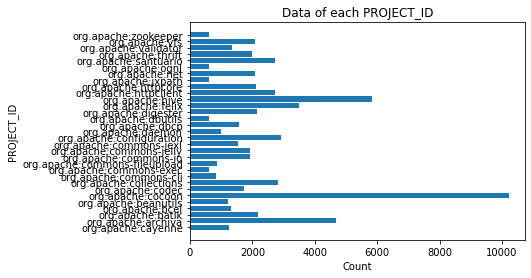

In [10]:
track('Starting plotting bar plots')
# Plot bar plots for the categorical variables with few values
# These are PROJECT_ID from SONAR_ANALYSIS table and SEVERITY and STATUS from SONAR_ISSUES table
track('--> Sonar analysis')
bar_plot(sonar_analysis["PROJECT_ID"],sonar_analysis,True,'sonar_analysis')

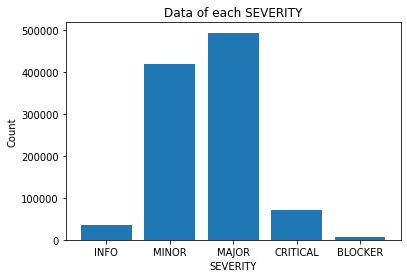

In [11]:
track('--> Sonar issues')
bar_plot(sonar_issues["SEVERITY"],sonar_issues,False,'sonar_issues')

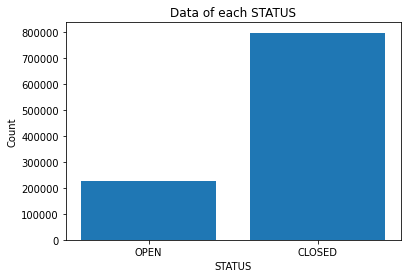

In [12]:
track('--> Sonar issues')
bar_plot(sonar_issues["STATUS"],sonar_issues,False,'sonar_issues')

track('Finished computing and saving the bar plots')

### Histogram plots 

In [13]:
track('Starting plotting histograms')
# Plot histogram of all numeric variables in dataframe

track("--> Git commits changes")
#plot_histogram(git_commits_changes,numerical,'git_commits_changes')

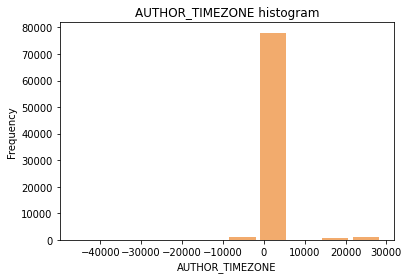

In [14]:
track('--> Git commits')
plot_histogram(git_commits,numerical,'git_commits')

In [15]:
track('--> Jira issues')
plot_histogram(jira_issues,numerical,'jira_issues')

In [16]:
track('--> Sonar analysis')
plot_histogram(sonar_analysis,numerical,'sonar_analysis')

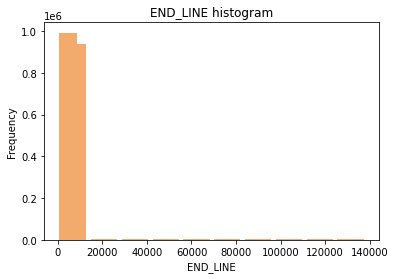

In [17]:
track('--> Sonar issues')
plot_histogram(sonar_issues,numerical,'sonar_issues')

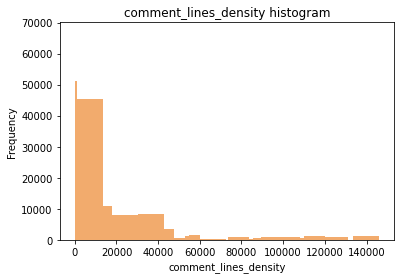

In [18]:
track('--> Sonar measures')
plot_histogram(sonar_measures,numerical,'sonar_measures')

track('Finishing computing and saving the histograms')

### Correlation plots 

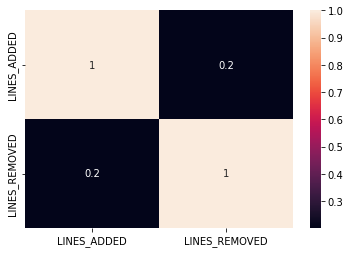

In [19]:
track('Starting plotting heatmaps of correlations')

# Plot heatmap of correlation of all numeric variables in dataframe

track('--> Git commits changes')
plot_correlations(git_commits_changes,numerical,'git_commits_changes')

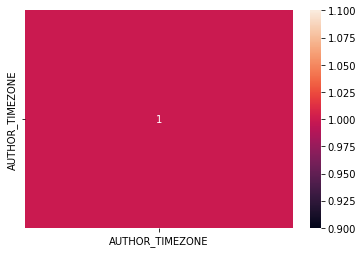

In [20]:
track('--> Git commits')
plot_correlations(git_commits,numerical,'git_commits')

In [21]:
track('--> Jira issues')
plot_correlations(jira_issues,numerical,'jira_issues')

In [22]:
track('--> Sonar analysis')
plot_correlations(sonar_analysis,numerical,'sonar_analysis')

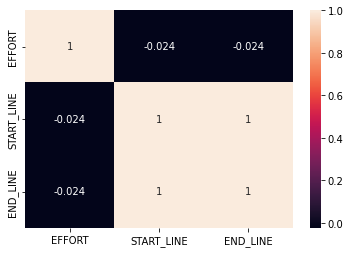

In [23]:
track('--> Sonar issues')
plot_correlations(sonar_issues,numerical,'sonar_issues')

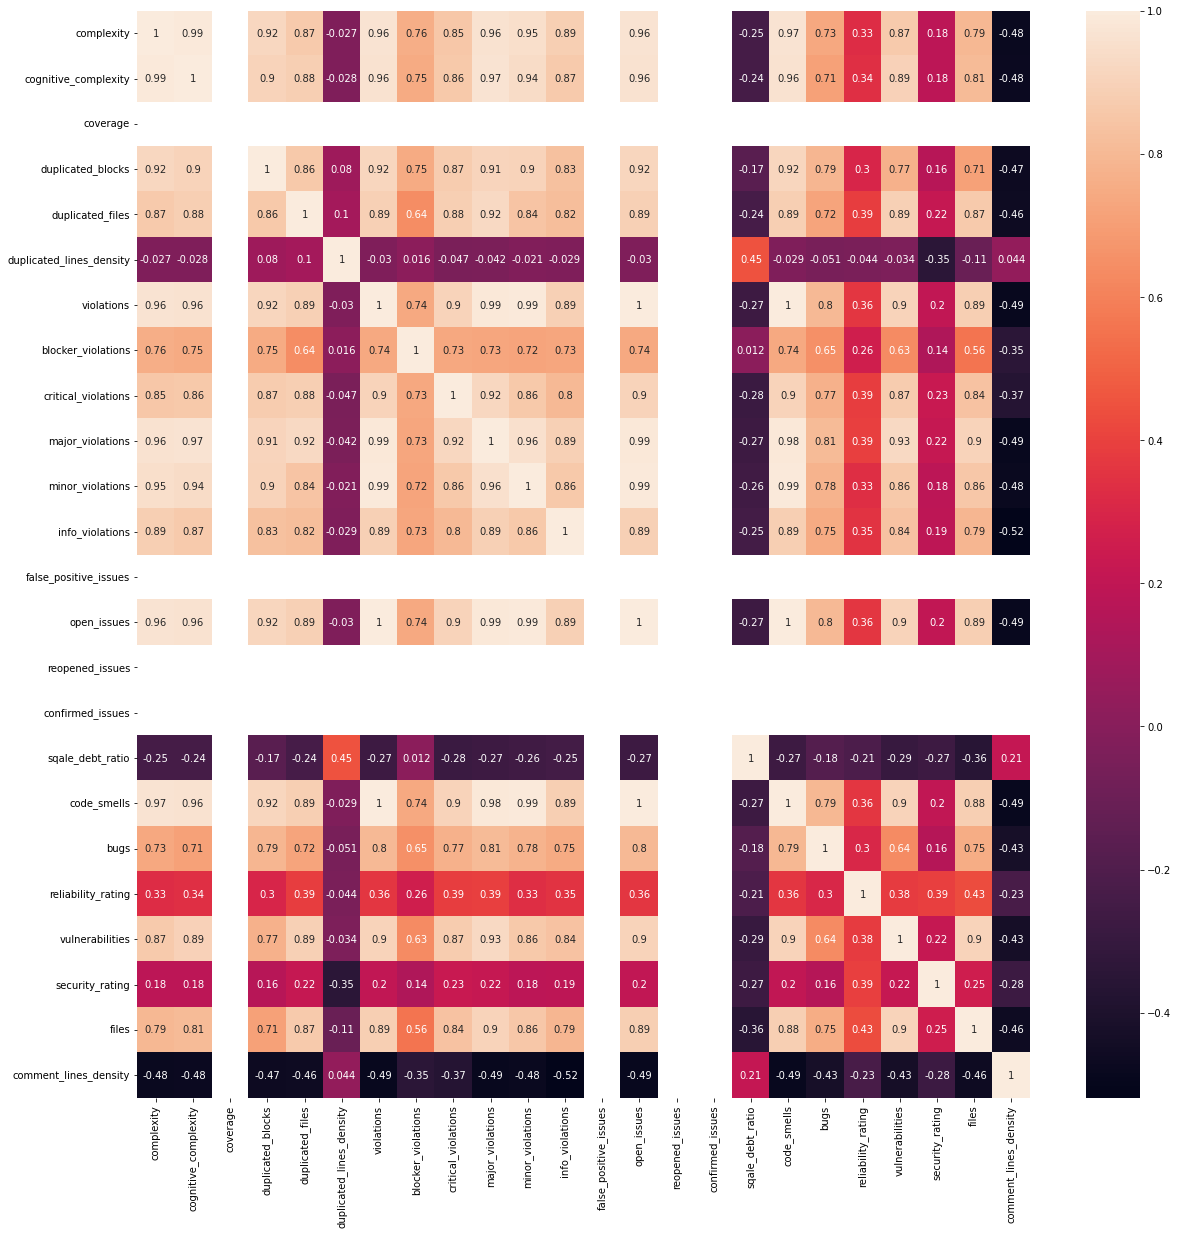

In [24]:
track('--> Sonar measures')
plot_correlations(sonar_measures,numerical,'sonar_measures')

track('Finished computing and saving the heatmap plots with correlations')

#  Checking data quality

In this section, an evaluation of the overall quality of the data for each table used in the project is performed.

**SONAR_MEASURES**

In [ ]:
track('-------------------------------------------------------------------------------')
track('Starting checking data quality')

## SONAR MEASURES
track('--> Sonar measures')
sonar_measures_txt = "sonar_measures_quality_analysis.txt"
print(initialize_doc(sonar_measures_txt,"Sonar measures"),end = "")
t1_result,fk_violations = check_FK(sonar_measures,'analysis_key',sonar_analysis,'ANALYSIS_KEY')
print(write_test_results(sonar_measures_txt,"FK",[t1_result,fk_violations]),end = "")
t2_result,_ = check_NAs(sonar_measures,sonar_measures_names)
print(write_test_results(sonar_measures_txt,"NA",t2_result),end = "")
t3_result = check_duplicates(sonar_measures)
print(write_test_results(sonar_measures_txt,"DUPLICATED",t3_result),end = "")

---------- SONAR MEASURES QUALITY ANALYSIS ----------


The test(s) that will be performed for the SONAR MEASURES table are:
 · Foreign key constraint
 · Presence of NAs
 · Duplicated rows
--------------------------------------------------------------------------------

**SONAR_ISSUES** 

In [ ]:
## SONAR ISSUES
track('--> Sonar issues')
sonar_issues_txt = "sonar_issues_quality_analysis.txt"
print(initialize_doc(sonar_issues_txt,"Sonar issues"),end = "")
t1_result,NA_columns = check_NAs(sonar_issues, sonar_issues_names)
print(write_test_results(sonar_issues_txt,"NA",t1_result),end = "")
t2_result = check_duplicates(sonar_issues)
print(write_test_results(sonar_issues_txt,"DUPLICATED",t2_result),end = "")

Checking if all the rows that don't have a starting line also don't have an end line.

In [ ]:
extra_intro = "As the % of START_LINE is equal to the one in the END_LINE, we will check if the rows match."
aux_start_end = sonar_issues[sonar_issues.START_LINE.notna()]
if aux_start_end.END_LINE.isna().sum() != 0:
    result = "There are rows with an START_LINE value that are missing the END_LINE value"
else: result = "All the rows match!"
print(extra_intro)
print(write_extra_info(sonar_issues_txt,"Extra check: missing values",result,extra_intro))

Checking if all the rows with missing CLOSE_ANALYSIS_KEY have STATUS = OPEN

In [ ]:
print(extra_intro)
extra_intro = "We will check if all the rows with missing CLOSE_ANALYSIS_KEY have STATUS = OPEN."
aux_cak = sonar_issues[sonar_issues.CLOSE_ANALYSIS_KEY.isna()]
if sum(aux_cak.STATUS == "OPEN")!= len(aux_cak):
    result = "There are " + str(len(aux_cak) - sum(aux_cak.STATUS == "OPEN"))+ " closed issues without closing analysis keys."
else: result = "All the rows match!"
print(write_extra_info(sonar_issues_txt,"Extra check: missing values",result,extra_intro))

**SONAR_ANALYSIS**

In [ ]:
## SONAR ANALYSIS
track('--> Sonar analysis')
sonar_analysis_txt = "sonar_analyisis_quality_analysis.txt"
print(initialize_doc(sonar_analysis_txt,"Sonar analysis"),end = "")
t1_result = check_PK(sonar_analysis,'ANALYSIS_KEY')
print(write_test_results(sonar_analysis_txt,"PK",t1_result),end = "")
t2_result,fk_violations = check_FK(sonar_analysis,'REVISION',git_commits,'COMMIT_HASH')
print(write_test_results(sonar_analysis_txt,"FK",[t2_result,fk_violations]),end = "")
t3_result = check_duplicates(sonar_analysis)
print(write_test_results(sonar_analysis_txt,"DUPLICATED",t3_result),end = "")

As problems in the PK were observed, a further quality examination has been performed. After a quick exploration, we noticed the presence of null values as PK in the analysis. Thus, we wanted to evaluate whether this was the only present problem and the number of rows affected by this phenomenon.

In [ ]:
extra_intro = "Further exploration on the PK repeated values"
if len(sonar_analysis[sonar_analysis['ANALYSIS_KEY'].notna()]) == len(sonar_analysis[sonar_analysis['ANALYSIS_KEY'].notna()].ANALYSIS_KEY.unique()):
    result = "All the repeated values on the PK variable are NAs." 
    result = result + "\n"+" "*3 +"The percentage of NA PK is: "+ str(round(sum(sonar_analysis.ANALYSIS_KEY.isna())/len(sonar_analysis)*100,3))+"%."
else: result = "The repeated values on the PK column are not NAs."
print(extra_intro)
print(write_extra_info(sonar_analysis_txt,"Extra check: pk violation",result,extra_intro))

**[EXTRA]**

In [ ]:
extra_intro = "After reporting the FK problem to Davide, he told us that he wanted to observe" \
              "wheteher all the rows that contained such problems were related to a an specific" \
              "project or affected to serveral ones. Thus, we performed such analysis:"
projects_with_fk_problems = [sonar_analysis[sonar_analysis.REVISION == x].PROJECT_ID for x in fk_violations]
projects_with_fk_problems = collections.Counter([x.values[0] for x in projects_with_fk_problems])
aux = collections.Counter(sonar_analysis.PROJECT_ID.values)
result = "The % of FK violations per projects are:\n" + '\n'.join(" "*6+x+" → "+str(round(projects_with_fk_problems[x]/aux[x]*100,4))+"%" for x in list(projects_with_fk_problems.keys()))
print(extra_intro)
print(write_extra_info(sonar_analysis_txt,"Extra check: fk violation",result,extra_intro))

**JIRA_ISSUES** 

In [ ]:
## JIRA ISSUES
track('--> Jira issues')
jira_issues_txt = "jira_issues_quality_analysis.txt"
print(initialize_doc(jira_issues_txt,"Jira issues"),end = "")
t1_result,fk_violations = check_FK(jira_issues,'HASH',git_commits,'COMMIT_HASH')
print(write_test_results(jira_issues_txt,"FK",[t1_result,fk_violations]),end = "")
t2_result = check_duplicates(jira_issues)
print(write_test_results(jira_issues_txt,"DUPLICATED",t2_result),end = "")

**GIT_COMMITS**

In [ ]:
## GIT COMMITS
track('--> Git commits')
git_commits_txt = "git_commits_quality_analysis.txt"
print(initialize_doc(git_commits_txt,"Git commits"),end = "")
t1_result = check_PK(git_commits,'COMMIT_HASH')
print(write_test_results(git_commits_txt,"PK",t1_result),end = "")
t2_result = check_dates(git_commits,'AUTHOR_DATE',datetime.today(),'1999',1)
print(write_test_results(git_commits_txt,"DATES RANGE",t2_result),end = "")
t3_result = check_missing_authors(git_commits,'AUTHOR')
print(write_test_results(git_commits_txt,"MISSING AUTHORS",t3_result),end = "")
t4_result = check_duplicates(git_commits)
print(write_test_results(git_commits_txt,"DUPLICATED",t4_result),end = "")

**GIT_COMMITS_CHANGES**

In [ ]:
## GIT COMMITS CHANGES
track('--> Git commits changes')
git_commits_changes_txt = "git_commits_changes_quality_analysis.txt"
print(initialize_doc(git_commits_changes_txt,"Git commits changes"),end = "")
t1_result = check_dates(git_commits_changes,'DATE',datetime.today(),'1999',2)
print(write_test_results(git_commits_changes_txt,"DATES RANGE",t1_result),end = "")
t2_result,fk_violations = check_FK(git_commits_changes,'COMMIT_HASH',git_commits,'COMMIT_HASH')
print(write_test_results(git_commits_changes_txt,"FK",[t2_result,fk_violations]),end = "")
t3_result,_ = check_NAs(git_commits_changes,git_commits_changes_names)
print(write_test_results(git_commits_changes_txt,"NA",t3_result),end = "")
t4_result = check_duplicates(git_commits_changes)
print(write_test_results(git_commits_changes_txt,"DUPLICATED",t4_result),end = "")

As the percentage of missing values is the same for all the columns, we will check if a row misses one value, misses all.

In [ ]:
extra_intro = "We will check if the NAs from different columns belong to the same rows."
aux_na = git_commits_changes[git_commits_changes.COMMIT_HASH.isna()]
na_bool = aux_na.isnull().all().all()
if na_bool:
    result = "If a row contains a NA value, there are also NAs for the rest of the columns."
else: result = "The NAs of the columns do not belong to a same subset of rows."
print(extra_intro)
print(write_extra_info(git_commits_changes_txt,"Extra check: missing values",result,extra_intro))

**TESTING POSSIBLE VALIDATION TABLES**

We are also interested in checking the ammount of rows that contain information about the final selected authors from the tables that we could use for validation.

To evaluate this, two things have to be performed:

* 1. Obtain the names of the final authors.

* 2. Check for the desired tables the number of maching authors.

In [ ]:
# Section 1: Obtaining the names of the final authors.

# First, we delete all the rows with NA values.
tables = [sonar_measures, sonar_issues, sonar_analysis, jira_issues,git_commits, git_commits_changes,szz,ref_min]
[sonar_measures, sonar_issues, sonar_analysis, jira_issues,git_commits, git_commits_changes,szz,ref_min] = delete_na(tables, dtypes)
sonar_measures = sonar_measures.reset_index(drop = True)
sonar_issues = sonar_issues.reset_index(drop = True)
sonar_analysis = sonar_analysis.reset_index(drop = True)
jira_issues = jira_issues.reset_index(drop = True)
git_commits = git_commits.reset_index(drop = True)
git_commits_changes = git_commits_changes.reset_index(drop = True)
szz = szz.reset_index(drop = True)
ref_min = ref_min.reset_index(drop= True) 

In [ ]:
# The join between the git related tables is performed.
gits=  pd.merge(git_commits, git_commits_changes, left_on='COMMIT_HASH', right_on='COMMIT_HASH', how='inner')

In [ ]:
#Joining SONAR_ANALYSIS with SONAR_MEASURES
sonar_measures_complete = pd.merge(sonar_measures, sonar_analysis, left_on = "analysis_key", right_on = "ANALYSIS_KEY", how = "inner")
sonar_measures_complete = sonar_measures_complete.drop(["analysis_key","ANALYSIS_KEY"],axis =1)

In [ ]:
# Deleting duplicated rows
sonar_measures_complete = sonar_measures_complete.drop_duplicates()
sonar_measures_complete = sonar_measures_complete.reset_index(drop = True)

In [ ]:
# Now,the commit hashes from the sonar tables will be replaced by the corresponding author.
# In order to execute the groupby functions, first we need to associate each commit to
# an author in the sonar_complete table. To do so, a dictionary of commit- author will be created.
commit_author_dict = {}
for i in range(len(git_commits)):
    commit_author_dict[git_commits["COMMIT_HASH"][i]] = git_commits["AUTHOR"][i]


In [ ]:
# Replacing the commit for the author.
sonar_measures_complete = change_commits_to_authors(sonar_measures_complete,"REVISION",commit_author_dict)

In [ ]:
# As we are only interested in the authors that have both information in the sonar measures and the gits table, 
# we will select only those.
sm_auth = set(sonar_measures_complete.Author)
gits_auth = set(gits.AUTHOR)

authors_interest = sm_auth.intersection(gits_auth)

In [ ]:
# SECTION 2 
# Once the names of the authors have been found, then we evaluate from the possible validation table how many
# authors we have information about.

# First, we substitute the respective hashes columns for the authors names.

jira_issues = change_commits_to_authors(jira_issues,"HASH",commit_author_dict)
szz = change_commits_to_authors(szz,"FAULT_INDUCING_COMMIT_HASH",commit_author_dict)
ref_min = change_commits_to_authors(ref_min,"COMMIT_HASH",commit_author_dict)

In [ ]:
track('--> Jira issues')
t1_result = check_matching(authors_interest,jira_issues,"Author")
print(write_test_results(jira_issues_txt,"AUTHORS OF INTEREST",t1_result),end = "")

In [ ]:
track('--> SZZ fault inducing commits ')
szz_txt = "szz_fault_inducing_commits_quality_analysis.txt"
print(initialize_doc(szz_txt,"Szz fault inducing commits"),end = "")
t1_result = check_matching(authors_interest,szz,"Author")
print(write_test_results(szz_txt,"AUTHORS OF INTEREST",t1_result),end = "")

In [ ]:
track('--> Refactoring miner')
ref_min_txt = "refactoring_miner_quality_analysis.txt"
print(initialize_doc(ref_min_txt,"Refactoring miner"),end = "")
t1_result = check_matching(authors_interest,ref_min,"Author")
print(write_test_results(ref_min_txt,"AUTHORS OF INTEREST",t1_result),end = "")